In [1]:
from pathlib import Path
from diffusers import AutoPipelineForText2Image, UNet2DConditionModel
import torch
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "5"


custom_sd_path = Path("/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model/")
custom_sd_path = "stabilityai/stable-diffusion-xl-base-1.0"

custom_adapter_path = Path(
    "/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model-T2I-pose-solo/"
)
custom_adapter_path = Path(
    "/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model-T2I-pose-PT/"
)
custom_adapter_path = Path(
    "/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model-T2I-pose-PT-sm/"
)
custom_adapter_path = Path(
    "/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model-T2I-pose-solo-test-xl"
)
custom_adapter_path = Path(
    "/local/scratch/carlyn.1/diffusion_models/sdxl-animalpose-model-T2I-pose-solo-xl/checkpoint-2000"
)
pose_image_path = Path(
    "/home/carlyn.1/code/FineDiffusion/pose_conditioning/notebooks/test_animalpose.png"
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    custom_sd_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

# pipeline.unet = UNet2DConditionModel.from_pretrained(custom_sd_path, subfolder="unet", torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

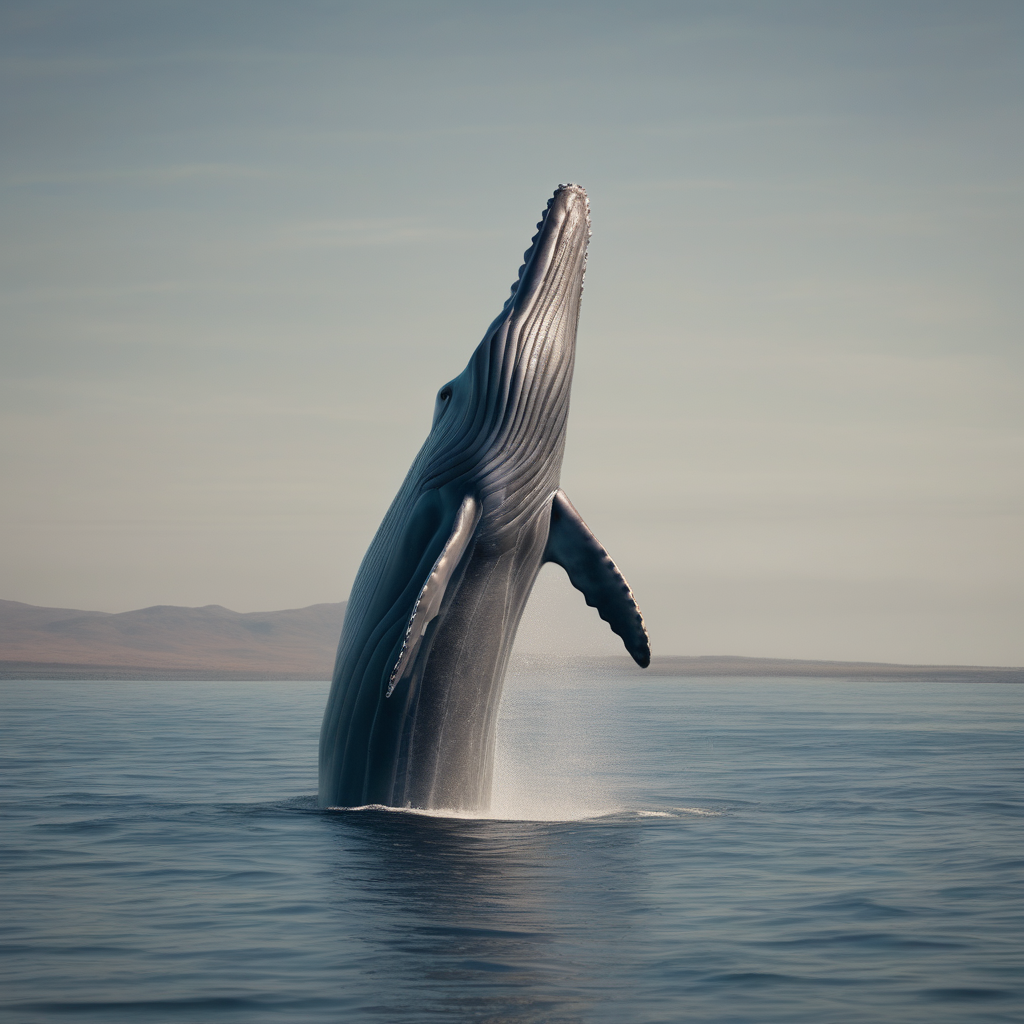

In [2]:
categories = [
    "jaguar",  # Majority classes
    "weasel",  # Majority classes
    "squirrel",  # Majority classes
    "black bear",  # Minority classes
    "marmot",  # Minority classes
    "alouwatta",  # Minority classes
    "dog",  # Easy class
]

# category = "okapi"  # categories[3]
category = "cat"  # categories[3]
image = pipeline(f"A photo of a {category}").images[0]
image

In [3]:
import torch
from diffusers import (
    StableDiffusionAdapterPipeline,
    StableDiffusionXLAdapterPipeline,
    T2IAdapter,
    EulerAncestralDiscreteScheduler,
)

adapter = T2IAdapter.from_pretrained(custom_adapter_path, torch_dtype=torch.float16)
pipeline = StableDiffusionXLAdapterPipeline.from_pretrained(
    custom_sd_path,
    adapter=adapter,
    torch_dtype=torch.float16,
)
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config
)
pipeline.enable_xformers_memory_efficient_attention()

# pipeline.unet = UNet2DConditionModel.from_pretrained(custom_sd_path, subfolder="unet", torch_dtype=torch.float16)
pipeline.to("cuda")

print("loaded")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

loaded


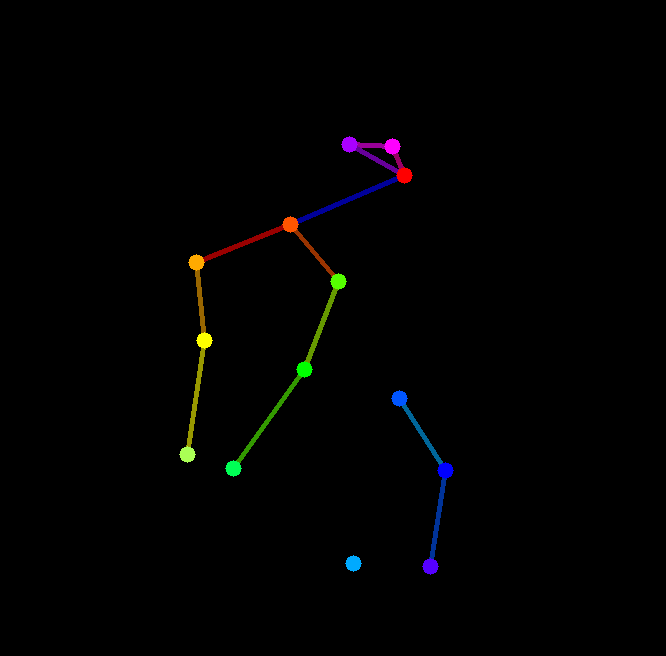

In [4]:
from diffusers.utils import load_image

cond_img = load_image(str(pose_image_path))
cond_img

  0%|          | 0/50 [00:00<?, ?it/s]

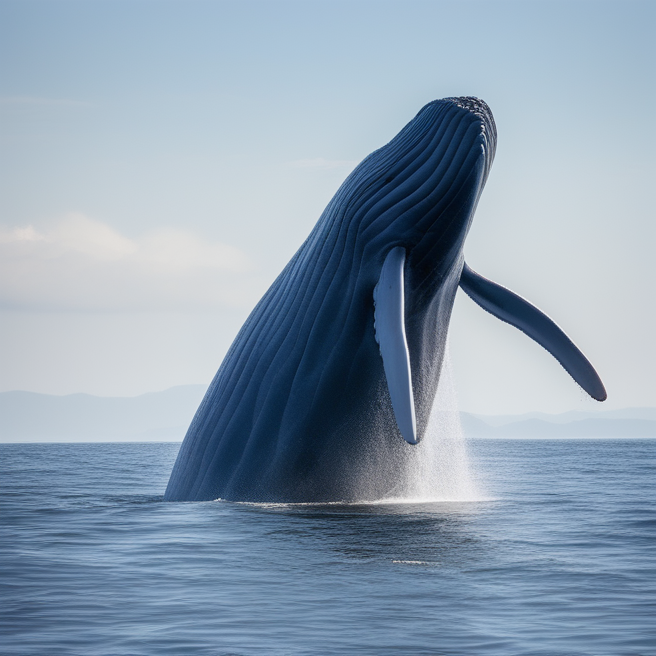

In [5]:
from PIL import Image
import numpy as np
from diffusers.utils import load_image

# cond_img = Image.open(pose_image_path)
cond_img = load_image(str(pose_image_path))


def null_safety(images, **kwargs):
    return images, False


pipeline.safety_checker = null_safety
image = pipeline(
    f"A photo of a {category}",
    adapter_conditioning_scale=1.0,
    image=cond_img,
    # num_inference_steps=30,
    # guidance_scale=7.5,
).images[0]

image